In [2]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re

BPM analysis from MD 16/06/2025

In [3]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta3.json')

tt = line.get_table()
tw = line.twiss()

#links for bump
env = line.env

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0
line['bump.12207'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
line.ref['mdh.12207'].knl[0] += line.vars['bump.12207']

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
bpm_data_dir = Path('../../MD_data/20250616/bpm/SPS.USER.MD2/')

# BPM classes MD 30/04/2025

In [4]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):

    @property 
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        #return self["orbit", "name"]
        return ak.Array([bpm for i, bpm in enumerate(self['name']) if self['plane'][i] == 'H'])
    
    @property
    def bpms_ver(self):
        return ak.Array([bpm for i, bpm in enumerate(self['name']) if self['plane'][i] == 'V'])
    
    def orbit_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['position'][self.index[bpm]] for bpm in self.bpms_hor])
        elif plane == 'V':
            return ak.Array([self['position'][self.index[bpm]] for bpm in self.bpms_ver])
        else:
            ValueError('No valid plane was given !')
    
    def rms_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['rms'][self.index[bpm]] for bpm in self.bpms_hor])
        elif plane == 'V':
            return ak.Array([self['rms'][self.index[bpm]] for bpm in self.bpms_ver])
        else:
            ValueError('No valid plane was given !')

    def orbit_position(self, name: str):
        # Return position for a given BPM name
        return self['position'][self.index[name]]
    
    def restr_orbit_plane(self, bpm_list_restr):
        return ak.Array([self['position'][self.index[bpm]] for bpm in bpm_list_restr])

    def restr_rms_plane(self, bpm_list_restr):
        return ak.Array([self['rms'][self.index[bpm]] for bpm in bpm_list_restr])
    
    def _build_index(self):
        self._index = {}
        for i, bpm in enumerate(self['name']):
            self._index[bpm] = i

class CorrectorsCollectionBehavior(ak.Array):
    @property 
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def corr_hor(self):
        #return self["orbit", "name"]
        return ak.Array([corr for i, corr in enumerate(self['name']) if self['plane'][i] == 'H'])
    
    @property
    def corr_ver(self):
        return ak.Array([corr for i, corr in enumerate(self['name']) if self['plane'][i] == 'V'])
    
    def kick_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['kick'][self.index[corr]] for corr in self.corr_hor])
        elif plane == 'V':
            return ak.Array([self['kick'][self.index[corr]] for corr in self.corr_ver])
        else:
            ValueError('No valid plane was given !')

    def kick_position(self, name: str):
        # Return position for a given BPM name
        return self['kick'][self.index[name]]

    def _build_index(self):
        self._index = {}
        for i, corr in enumerate(self['name']):
            self._index[corr] = i


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior
ak.behavior["*", "CorrectorsCollection"] = CorrectorsCollectionBehavior

In [21]:
def load_bpm_file_data(path: Union[str, Path]) -> ak.Array:
    """
    Load a .data or .data.gz file into an Awkward Array with BPMCollection behavior.
    """

    #file opening with different compression
    path = Path(path)
    opener = gzip.open if path.suffix == ".gz" else open
    with opener(path, "rt") as f:
        lines = f.readlines()

    #Sections of file
    header_lines = []
    orbit_lines = []
    corrector_lines = []

    mode = "header"
    for line in lines:
        if line.startswith("# MONITOR"):
            mode = "orbit"
            continue
        elif line.startswith("# CORRECTOR"):
            mode = "corrector"
            continue

        if mode == "header":
            header_lines.append(line)
        elif mode == "orbit":
            if not line.startswith('*'):
                orbit_lines.append(line)
        elif mode == "corrector":
            if not line.startswith('*'):
                corrector_lines.append(line)

    #Metadata
    meta = {}  # <-- parse @ DATE, @ DPP, etc.
    for line in header_lines:
        if not line.startswith('@'):
            continue
        parts = line.strip().split(maxsplit=3)
        if len(parts) < 4:
            continue
        _, key, dtype, value = parts
        if dtype == "%d":
            value = int(value)
        elif dtype == "%f":
            value = float(value)
        elif dtype == "%s":
            value = value.strip('"')
        meta[key] = ak.Array([value])
    
    
    #Orbit
    orbit = {
        "name": [], "plane": [], "beam": [], "position": [],
        "rms": [], "sum": [], 'hw-status': [], 'status' : [], "status_tag": [],
    }
    # Fill orbit[...] from orbit_lines
    for line in orbit_lines:
        parts = line.strip().split(maxsplit=9)
        assert len(parts)==9
        for i, key in enumerate(list(orbit.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    orbit[key].append(float(value))
                else:
                    orbit[key].append(int(value))
            except ValueError:
                if key == 'name':
                    orbit[key].append(value.lower())
                else:
                    orbit[key].append(value)
    
    for key in orbit:
        orbit[key]=ak.Array(orbit[key])
    
    #Correctors
    correctors = {
        "name": [], "plane": [], "beam": [], 'strength_name' : [], "kick": [], "rt_kick": [],
    }
    # Fill correctors[...] from corrector_lines
    for line in corrector_lines:
        parts = line.strip().split(maxsplit=6)
        assert len(parts)==6
        for i, key in enumerate(list(correctors.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    correctors[key].append(float(value))
                else:
                    correctors[key].append(int(value))
            except ValueError:
                if key=='name':
                    correctors[key].append(value.lower())
                else:
                    correctors[key].append(value)
    
    for key in correctors:
        correctors[key]=ak.Array(correctors[key])

    #Total dictionary data, idk how to make awkward array out of it
    data = {
        "orbit": ak.Array(orbit, with_name='BPMCollection'),
        "correctors": ak.Array(correctors, with_name='CorrectorsCollection'),
        "meta": ak.Array(meta),
    }

    return data


In [23]:
# def load_all_bpm_files(directory_coll):
#     bpm_files_by_timestamp = {}

#     pattern = re.compile(r"ORBIT_SPSRING_(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_.*\.data\.gz")

#     for file in Path(directory_coll).glob("ORBIT_SPSRING_*.data.gz"):
#         match = pattern.match(file.name)
#         if match:
#             timestamp_raw = match.group(1)
#             try:
#                 date_part, time_part = timestamp_raw.split('_')
#                 timestamp_str = f"{date_part} {time_part.replace('-', ':')}"
#                 timestamp = pd.Timestamp(timestamp_str, tz='Europe/Paris')
#                 bpm_files_by_timestamp[timestamp] = load_bpm_file_data(file)

#             except (AssertionError, EOFError, OSError, ValueError) as e:
#                 print(f"Skipping file due to error ({type(e).__name__}): {file}")
#                 continue

#     return bpm_files_by_timestamp

def load_all_bpm_files(directory_coll):
    bpm_files_by_timestamp = {}

    # New pattern to match: 2025.06.16.14.52.30.123456.parquet
    pattern = re.compile(r"(\d{4})\.(\d{2})\.(\d{2})\.(\d{2})\.(\d{2})\.(\d{2})\.(\d{6})\.parquet")

    for file in Path(directory_coll).glob("*.parquet"):
        match = pattern.match(file.name)
        if match:
            try:
                year, month, day, hour, minute, second, microsecond = map(int, match.groups())
                timestamp = pd.Timestamp(
                    year=year, month=month, day=day,
                    hour=hour, minute=minute, second=second,
                    microsecond=microsecond, tz='Europe/Paris'
                )
                bpm_files_by_timestamp[timestamp] = load_bpm_file_data(file)

            except (AssertionError, EOFError, OSError, ValueError) as e:
                print(f"Skipping file due to error ({type(e).__name__}): {file}")
                continue

    return bpm_files_by_timestamp

# Testing data files

In [25]:
bpms_hor_in_line = ['bph.10208',
 'bph.10408',
 'bph.10608',
 'bph.10808',
 'bph.11008',
 'bph.11208',
 'bph.11408',
 'bph.11608',
 'bph.11831',
 'bph.12008',
 'bph.12208',
 'bph.12408',
 'bph.12608',
 'bph.12808',
 'bph.13008',
 'bph.13208',
 'bph.13408',
 'bph.13608',
 'bph.20208',
 'bph.20408',
 'bph.20608',
 'bph.20808',
 'bph.21008',
 'bph.21208',
 'bph.21408',
 'bpce.21604',
 'bpce.21706',
 'bpce.21803',
 'bph.22008',
 'bph.22208',
 'bph.22408',
 'bph.22608',
 'bph.22808',
 'bph.23008',
 'bph.23208',
 'bph.23408',
 'bph.23608',
 'bph.30208',
 'bph.30408',
 'bph.30608',
 'bph.30808',
 'bph.31008',
 'bph.31208',
 'bph.31408',
 'bph.31608',
 'bph.31808',
 'bph.32008',
 'bph.32208',
 'bph.32408',
 'bph.32608',
 'bph.32808',
 'bph.33008',
 'bph.33208',
 'bph.33408',
 'bph.33608',
 'bph.40208',
 'bph.40408',
 'bph.40608',
 'bph.40808',
 'bph.41008',
 'bph.41208',
 'bph.41408',
 'bpce.41705',
 'bpce.41801',
 'bpce.41931',
 'bph.42008',
 'bph.42208',
 'bph.42408',
 'bph.42608',
 'bph.42808',
 'bph.43008',
 'bph.43208',
 'bph.43408',
 'bph.43608',
 'bph.50208',
 'bph.50408',
 'bph.50608',
 'bph.50808',
 'bph.51008',
 'bph.51208',
 'bph.51408',
 'bpce.51604',
 'bpce.51833',
 'bph.52008',
 'bph.52208',
 'bph.52408',
 'bph.52608',
 'bph.52808',
 'bph.53008',
 'bph.53208',
 'bph.53408',
 'bph.53608',
 'bph.60208',
 'bph.60408',
 'bph.60608',
 'bph.60808',
 'bph.61008',
 'bph.61208',
 'bph.61408',
 'bph.61608',
 'bpce.61705',
 'bpce.61804',
 'bpce.61931',
 'bph.62008',
 'bph.62208',
 'bph.62408',
 'bph.62608',
 'bph.62808',
 'bph.63008',
 'bph.63208',
 'bph.63408',
 'bph.63608']

## Testing fields

In [2]:
test = ak.from_parquet('../../MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.16.30.49.701455.parquet')

In [8]:
test[0].fields

['BPMALPS_1/CaptureAcquisition',
 'BPMALPS_2/CaptureAcquisition',
 'BPMALPS_3/CaptureAcquisition',
 'BPMALPS_4/CaptureAcquisition',
 'BPMALPS_5/CaptureAcquisition',
 'BPMALPS_6/CaptureAcquisition']

In [5]:
test2 = ak.from_parquet('../../MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.10.22.25.685576.parquet')

In [ ]:
test2['BPMALPS_6/CaptureAcquisition'].fields#There is value where the 

['exception', 'header', 'value']

In [26]:
test2['BPMALPS_6/CaptureAcquisition']['exception']

<Array [''] type='1 * ?string'>

In [27]:
test2['BPMALPS_6/CaptureAcquisition']['header']

<Array [{acqStamp: 1750062144935099800, ...}] type='1 * ?{acqStamp: ?int64,...'>

In [29]:
test2['BPMALPS_6/CaptureAcquisition']['value'].fields

['batchSelection',
 'beamTypeUsed',
 'channelMode',
 'channelNames',
 'channelPlanes',
 'delayMs',
 'measStamp',
 'measStamp_units',
 'nbOfAcqs',
 'nbOfChannels',
 'nbOfSlotsSelected',
 'nbOfTurnsAcquired',
 'nbOfTurnsRequested',
 'observables',
 'position_unit',
 'position_unitExponen',
 'positions']

## Trying to load all files from a directory

In [32]:
parquet_paths = list(bpm_data_dir.glob("*.parquet"))

In [ ]:
#Loading parquet files into a dictionary
bpm_dict = {}
for path in parquet_paths:
    bpm_dict[path.stem] = ak.from_parquet(path)

In [ ]:
#Checking for files with no data, which is indicated by the exception field
#If the exception field contains 'NO_DATA_AVAILABLE_FOR_USER', it means no data is available
fails_dict = {}
for ts_name in bpm_dict:
    fails_dict[ts_name] = 0 
    for field in bpm_dict[ts_name].fields:
        if 'NO_DATA_AVAILABLE_FOR_USER' in bpm_dict[ts_name][field]['exception'][0]:
            fails_dict[ts_name] += 1
    if fails_dict[ts_name] > 0:
        print(f"{ts_name} has {fails_dict[ts_name]} fields with no data available for user")

2025.06.16.10.22.16.190870 has 6 fields with no data available for user


## Getting all cyclestamps
It was tested in swan that it is indeed only SPS.USER.MD2

In [51]:
test2['BPMALPS_2/CaptureAcquisition']['header']['cycleStamp']

<Array [1750062141735000000] type='1 * ?int64'>

In [57]:
acqstamps = []
for ts in bpm_dict:
    if ts != '2025.06.16.10.22.16.190870':
        acqstamps.append(int(bpm_dict[ts]['BPMALPS_1/CaptureAcquisition']['header']['cycleStamp'][0]))

## Plot tests

 ...]

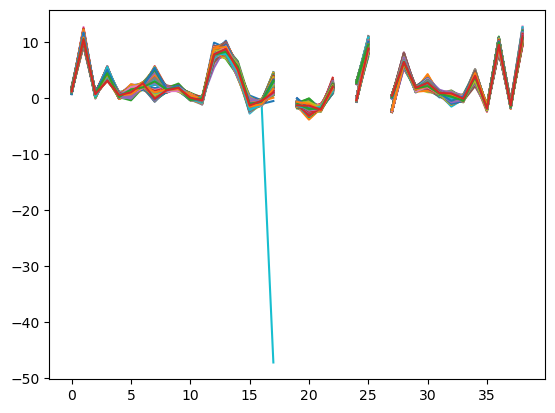

In [ ]:
plt.plot(test2['BPMALPS_1/CaptureAcquisition']['value']['positions'][0])

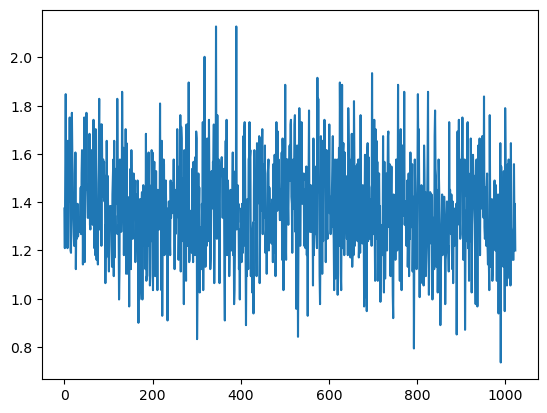

In [69]:
plt.plot(test2['BPMALPS_1/CaptureAcquisition']['value']['positions'][0][0])

## Testing for bpm names
They are in capital, plane is indicated, which does not correspond in line.element_names  
Also, bpm drifts in line are probably split for some reason

In [75]:
test2['BPMALPS_1/CaptureAcquisition']['value']['channelNames'][0]

<Array ['BPV.10108.V', 'BPH.10208.H', ..., 'SPARE'] type='40 * ?string'>

In [96]:
s = 'BPV.10108.V'.split('.')[0].lower()+'.'+'BPV.10108.V'.split('.')[1]

In [10]:
p = 0
p_tot = 0
for cap_name in test2['BPMALPS_6/CaptureAcquisition']['value']['channelNames'][0]:
    if cap_name != 'SPARE':
        p_tot += 1
        name = cap_name.split('.')[0].lower()+'.'+cap_name.split('.')[1]
        presence = False
        for elem_name in line.element_names:
            if elem_name.startswith(name):
                presence = True
                p += 1
                break
        if not presence:
            print(f"{name} is not present in the line !")

bph.41608 is not present in the line !

## Testing positions

As in post-mortem, only 1024 turns. Is there a file every 1024 turns or is it really the post-mortem for our cycle?

In [78]:
test2['BPMALPS_1/CaptureAcquisition']['value']['positions'][0][0]

<Array [1.37, 1.21, 1.53, 1.85, ..., 1.31, 1.39, 1.2] type='1024 * ?float32'>

In [86]:
test2['BPMALPS_1/CaptureAcquisition']['value']['nbOfTurnsAcquired']

<Array [1024] type='1 * ?int32'>

In [88]:
1/200_000_000 * 1024

5.12e-06

In [89]:
1/200_000_000

5e-09

In [90]:
acqstamps

[1750084245735000000,
 1750088661735000000,
 1750086646935000000,
 1750084908135000000,
 1750088192535000000,
 1750079612535000000,
 1750084742535000000,
 1750086150135000000,
 1750064913735000000,
 1750095692535000000,
 1750067746935000000,
 1750081376535000000,
 1750069048935000000,
 1750084604535000000,
 1750092351735000000,
 1750082562135000000,
 1750097161335000000,
 1750086315735000000,
 1750087171335000000,
 1750093772535000000,
 1750097630535000000,
 1750098348135000000,
 1750081706535000000,
 1750097520135000000,
 1750085377335000000,
 1750063317735000000,
 1750093657335000000,
 1750085239335000000,
 1750095769335000000,
 1750081982535000000,
 1750097188935000000,
 1750062183735000000,
 1750083500535000000,
 1750098872535000000,
 1750088358135000000,
 1750089048135000000,
 1750083058935000000,
 1750098486135000000,
 1750093849335000000,
 1750085736135000000,
 1750089710535000000,
 1750083307335000000,
 1750092390135000000,
 1750093119735000000,
 1750095423735000000,
 175008104

# BPM class development

In [ ]:
from typing import Optional, Tuple, Union, Set, List
import re



class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        return ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    @property
    def bpms_ver(self):
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        return ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    @property
    def hor_turn_position(self):
        return ak.Array([self._full_index[bpm]['positions'] for bpm in self.bpms_hor])
    
    @property
    def ver_turn_position(self):
        return ak.Array([self._full_index[bpm]['positions'] for bpm in self.bpms_ver])
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [ ]:
# def _build_full_index(self):
    #     self._full_index = {}

    #     nb_bpms = 0
    #     for crate in self.fields:
    #         for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
    #             if bpm != 'SPARE':
    #                 nb_bpms += 1
    #                 split_bpm = bpm.split('.')
    #                 bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
    #                 plane = split_bpm[2]
    #                 if bpm_name not in self._full_index:
    #                     self._full_index[bpm_name] = {}
    #                 self._full_index[bpm_name]['plane'] = plane
    #                 self._full_index[bpm_name]['index'] = nb_bpms - 1
    #                 self._full_index[bpm_name]['crate'] = crate
    #                 self._full_index[bpm_name]['positions'] = self[crate]['value']['positions'][0][i]

In [18]:
test3 = ak.Array(ak.from_parquet('../../MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.10.22.25.685576.parquet'), with_name='BPMCollection')